In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape # 70k images, 784 features (28x28 pixels)

(70000, 784)

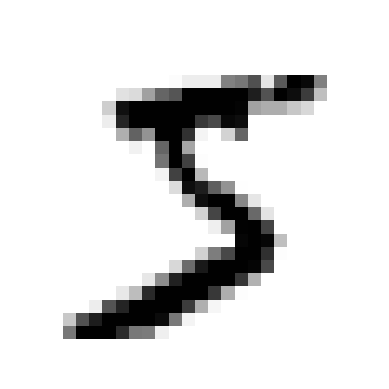

In [5]:
some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28, 28) # create image from 1D array
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# label
print(y[0])
print(type(y[0]))

5
<class 'str'>


In [7]:
# convert string to int
y = y.astype(np.uint8)

In [8]:
# train test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# binary classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit]) # predict the digit 5 (True is 5, False is not 5)

C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [11]:
# cross validation check

from sklearn.model_selection import cross_val_score
score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

print(score)

[0.95035 0.96035 0.9604 ]


In [14]:
# cross validation check with custom implementation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [15]:
# Dummy classifier

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

score = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(score) # [0.91125 0.90855 0.90915]

# It's means only 10% of the data is 5, so if you always guess that the image is not 5, you will be right 90% of the time.

[0.91125 0.90855 0.90915]


In [16]:
# confusion matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix = pd.crosstab(y_train_5, y_train_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
# True Negative: 53892, False Positive: 687
# False Negative: 1891, True Positive: 3530

# accuracy = TN + TP / (TN + FP + FN + TP) = 53892 + 3530 / (53892 + 687 + 1891 + 3530) = 0.9502 %
# precision = TP / (TP + FP) = 3530 / (3530 + 687) = 0.84  
# recall = TP / (TP + FN) = 3530 / (3530 + 1891) = 0.65 %
# f1 = 2 * (precision * recall) / (precision + recall) = 2 * (0.84 * 0.65) / (0.84 + 0.65) = 0.74 % 

Predicted  False  True 
Actual                 
False      53892    687
True        1891   3530


In [ ]:
# precision and recall ratio

# we cannot change the threshold of the model, but we can change the threshold of the decision function

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0 # default threshold
y_some_digit_pred = (y_scores > threshold) # True
print(y_some_digit_pred)

# make the threshold higher
threshold = 8000

y_some_digit_pred = (y_scores > threshold) # False
print(y_some_digit_pred)


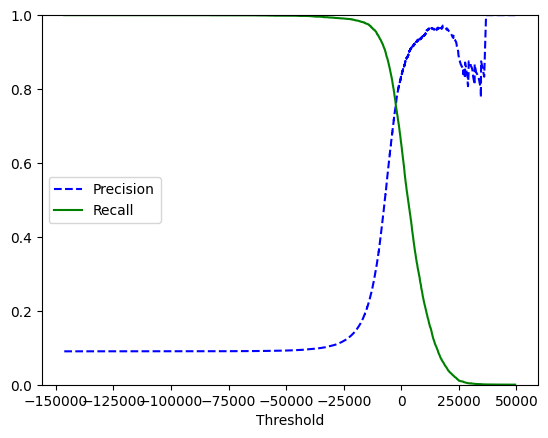

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('Threshold for 90 % accuracy is: ', threshold_90_precision)

x_train_pred_90 = (y_scores >= threshold_90_precision)

pre_score = precision_score(y_train_5, x_train_pred_90)
rec_score = recall_score(y_train_5, x_train_pred_90)

print(pre_score) # 0.90 % precision increased
print(rec_score) # 0.48 %  recall decreased

Threshold for 90 % accuracy is:  3370.0194991439557
0.9000345901072293
0.4799852425751706


In [ ]:
# ROC curve